In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skeleton import skeleton
G, color_edge = skeleton()

In [2]:
def pts3d_to_angle(pts3d,G):
    '''compute joint angles from DeepFly3D'''
    
    n = int(len(G.nodes))
    j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    err_j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    
    for j in range(1, n): #joint
        if G.degree(j) == 2:    
            nb = [n for n in G.neighbors(j)]
                
            j_angles[:, j], err_j_angles[:, j] = cos_rule(pts3d[:, nb[0], :], pts3d[:, j, :], pts3d[:, nb[1], :])
            
    j_angles[np.logical_or(np.isnan(j_angles), np.isinf(j_angles))] = 0

    return j_angles, err_j_angles


def cos_rule(a, b, c):
    '''cos-rule between angle spanned by 3 points'''
    
    ba = a - b
    bc = c - b
    
    dotbabc = np.einsum("ij,ij->i", ba, bc)
    normba = np.linalg.norm(ba, axis=1)
    normbc = np.linalg.norm(bc, axis=1)
    
    varba = np.std(normba)
    varbc = np.std(normbc)
    
    cos_angle = dotbabc / (normba * normbc)
    angle = np.arccos(cos_angle)
    
    #uncertainty = x.y/|x||y| sqrt((d|x|/|x|)^2 + (d|y|/|y|)^2)
    angle_err = angle * np.sqrt( (varba/normba)**2+(varbc/normbc)**2 )
    
    return angle, angle_err


def get_coords_in_dim(targets, dim):
    
    if len(targets)>1:
        dim_to_use = []
        for i in targets:
            dim_to_use += i
    else:
        dim_to_use = targets
  
    dim_to_use = np.array(dim_to_use)
    if dim == 2:    
        dim_to_use = np.sort( np.hstack( (dim_to_use*2, dim_to_use*2+1)))
  
    return dim_to_use


def unNormalizeData(data, data_mean, data_std):
    """
    Un-normalizes a matrix whose mean has been substracted and that has been divided by
    standard deviation. Some dimensions might also be missing
    """
    data *= data_std
    data += data_mean
    
    return data


def expand(data,dim_to_use,dim):
    
    T = data.shape[0]
    D = dim
    orig_data = np.zeros((T, D), dtype=np.float32)
    orig_data[:,dim_to_use] = data
    
    return orig_data

In [5]:
data_dir = '/data/LiftFly3D/prism/data_oriented'
        
#load predictions
data = torch.load(data_dir + '/test_results.pth.tar')

#target
target_sets = torch.load(data_dir + '/stat_3d.pth.tar')['target_sets']    
tar_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
tar_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
tar_offset = torch.load(data_dir + '/stat_3d.pth.tar')['offset']
tar_offset = np.vstack( tar_offset.values() ) 
targets_1d = get_coords_in_dim(target_sets, 1)

tar = unNormalizeData(data['target'], tar_mean[targets_1d], tar_std[targets_1d])
tar = expand(tar,targets_1d,len(tar_mean))
tar += tar_offset[0,:]

#output
out = unNormalizeData(data['output'], tar_mean[targets_1d], tar_std[targets_1d])
out = expand(out,targets_1d,len(tar_mean))
out += tar_offset[0,:] 

#inputs
inp_mean = torch.load(data_dir + '/stat_2d.pth.tar')['mean']
inp_std = torch.load(data_dir + '/stat_2d.pth.tar')['std']
inp_offset = torch.load(data_dir + '/stat_2d.pth.tar')['offset']
inp_offset = np.vstack( inp_offset.values() )
targets_2d = get_coords_in_dim(target_sets, 2)
inp = unNormalizeData(data['input'], inp_mean[targets_2d], inp_std[targets_2d])
inp = expand(inp,targets_2d,len(inp_mean))
inp += inp_offset[0,:] 

bool_LR = data['bool_LR']
chng_pt = np.where(np.diff(1*bool_LR[:,0])<0)[0]
#inp = inp[np.where(bool_LR[:,0])[0],:]
#tar = tar[np.where(bool_LR[:,0])[0],:]
#out = out[np.where(bool_LR[:,0])[0],:]
poses = np.stack((inp[:,::2],inp[:,1::2],out), axis=2)

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [6]:
poses.shape

(1637, 30, 3)

In [15]:
j_angles, err_j_angles = pts3d_to_angle(poses,G)
scale = 2.5/400
j_angles = np.degrees(j_angles)
j_angles -= np.mean(j_angles,axis=0)
err_j_angles = np.degrees(err_j_angles)

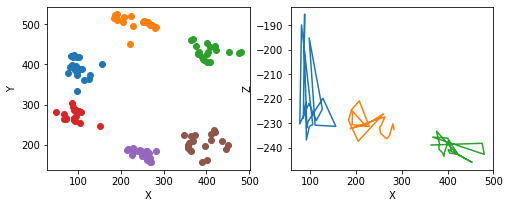

In [8]:
fig = plt.figure(figsize=([8,3])) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#ax3 = fig.add_subplot(1, 2, 3)
#ax4 = fig.add_subplot(1, 2, 4)
#ax3 = fig.add_subplot(2, 2, 3, projection='3d') 

times = np.arange(20)
for i in [4,9,14,19,24,29]:
    ax1.plot(poses[times,i,0],poses[times,i,1],'o') 
       
for i in [4,9,14]: #plot projected tarsus coordinates
    ax2.plot(poses[times,i,0],-poses[times,i,2])
    
    #ax3.plot3D(data[:,i,0], data[:,i,1], data[:,i,2],'ro')
    
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')

#ax3.set_xlabel('dim 1')
#ax3.set_ylabel('dim 2')
#ax3.set_zlabel('dim 3')
plt.show()

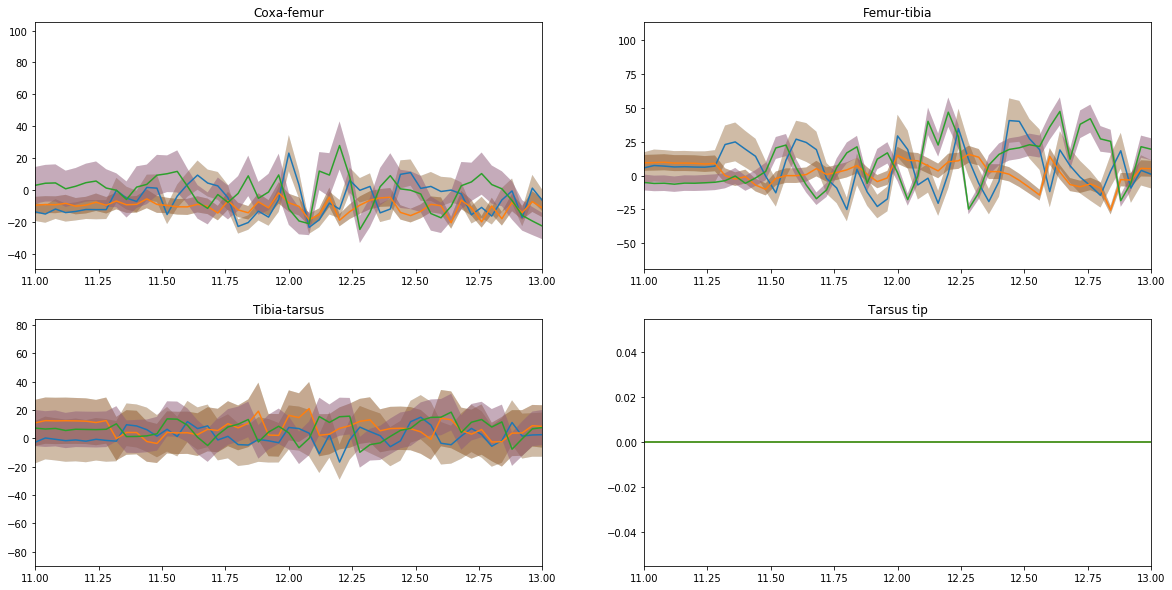

In [33]:
freq = 1/25
f, axs = plt.subplots(2, 2, figsize=(20,10))
time = np.arange(poses.shape[0])*freq

def plot_epoch(tint, j_angles, err_j_angles, joints, title, ax):
    ax.set_title(title)
    for j in joints:
        ax.plot(time, j_angles[:,j])
        ax.fill_between(time, j_angles[:,j] - err_j_angles[:,j] , j_angles[:,j] + err_j_angles[:,j], alpha=0.3)
        ax.fill_between(time, j_angles[:,j] - err_j_angles[:,j] , j_angles[:,j] + err_j_angles[:,j], alpha=0.3)
        
    #for i in chng_pt:
    #    if time[i]>=tint[0] & time[i]<tint[1]:
    #        ax.axvline(x=time[i])
        
    ax.set_xlim([tint[0], tint[1]])  

tint = [11,13]
plot_epoch(tint, j_angles, err_j_angles, [1,6,11], 'Coxa-femur', axs[0,0])
plot_epoch(tint, j_angles, err_j_angles, [2,7,12], 'Femur-tibia', axs[0,1])
plot_epoch(tint, j_angles, err_j_angles, [3,8,13], 'Tibia-tarsus', axs[1,0])
plot_epoch(tint, j_angles, err_j_angles, [4,9,14], 'Tarsus tip', axs[1,1])

